<a href="https://colab.research.google.com/github/jaylim2216/sentence-sentiment-analysis/blob/main/IT1244_Team48_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis using logistic regression

The **`sentence sentiment`** data set consists of 10,662 sentences. Each sentence is labeled according to whether it comes from a positive review or negative review.

We will use <font color="magenta">logistic regression and support vector machine</font> to learn a classifier from this data.

Articles/Research Papers used:
1. https://medium.com/@lope.ai/sentiment-analysis-fbea6cc9fd29
2. https://doi.org/10.1016/j.gltp.2022.03.012
3. https://medium.com/analytics-vidhya/sentimental-analysis-using-svm-support-vector-machine-812f2454fbc5


## Set up notebook, load data

In [ ]:
%matplotlib inline
import csv
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import re

from nltk.corpus import stopwords
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

Now, we load in the data. The data file is titled `dataset.csv` and we shall take a look at how the sentences look like before cleaning up the noise

The data set consists of 10,662 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review).

In [ ]:
# Initialize empty lists to store sentences and labels
sentences = []
labels = []

# Read the data from the CSV file
with open("dataset.csv") as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        if len(row) == 2:
            label, sentence = row
            sentence = sentence.replace("\\", "").replace('"', '')
            sentences.append(sentence)
            labels.append(int(label))

y = np.array(labels, dtype='int8')

sentences[:10]

["the rock is destined to be the 21st century's new  conan  and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .",
 "the gorgeously elaborate continuation of  the lord of the rings  trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .",
 'effective but too-tepid biopic',
 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",
 'the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .',
 'offers that rare combination of entertainment and education .',
 'perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .',
 "steers turns in a snap

### Preprocessing the text data

We will do four transformations:

1. Remove ordinals, punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a TF-IDF representation.

We begin with first two steps.

In [ ]:
## remove_ordinals takes a list text_list
## returns cleaned_list with ordinals 'st', 'nd','rd','th' in sentences replaced by ''

## full_remove takes a string x and a list of characters removal_list
## returns x with all the characters in removal_list replaced by ' '


pattern = r'\b\d+(st|nd|rd|th)\b'
def remove_ordinals(text_list):
    cleaned_list = []
    for text in text_list:
        cleaned_text = re.sub(pattern, '', text)
        cleaned_list.append(cleaned_text)
    return cleaned_list

def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, '')
    return x

## Remove ordinals and digits
sentences = remove_ordinals(sentences)
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have imported a list of stopwords from ntlk.

In [ ]:
## Define our stop words
nltk.download('stopwords')
stop_set = set(stopwords.words('english'))

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's take a look at what the sentences look like so far

In [ ]:
sents_processed[:10]

['rock destined centurys new conan hes going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal',
 'gorgeously elaborate continuation lord rings trilogy huge column words cannot adequately describe cowriterdirector peter jacksons expanded vision j r r tolkiens middleearth',
 'effective tootepid biopic',
 'sometimes like go movies fun wasabi good place start',
 'emerges something rare issue movie thats honest keenly observed doesnt feel like one',
 'film provides great insight neurotic mindset comics even reached absolute top game',
 'offers rare combination entertainment education',
 'perhaps picture ever made literally showed road hell paved good intentions',
 'steers turns snappy screenplay curls edges clever want hate somehow pulls',
 'take care cat offers refreshingly different slice asian cinema']

### Feature Representation (TF-IDF)

In Article 1, we see that they used the Bag-Of-Words model with CountVectorizer. To improve the performance of our own model, we chose to use the TfIdfVectorizer instead.

The TfidfVectorizer from scikit-learn converts a collection of preprocessed sentences (sents_processed) into a TF-IDF matrix, which reflects the relative importance of words within the dataset by considering their frequency across documents. This representation with TF-IDF weighting is limited to the top 7000 terms to focus on the most significant features and weed out spelling mistakes and words which occur too infrequently.

After transforming the sentences into TF-IDF features and converting the sparse matrix to a dense array (tfidf_mat), the code appends a column of ones to the matrix. This additional column serves as a bias term for subsequent modeling, ensuring that the machine learning algorithms can handle inputs where all other features are zero, thereby enhancing the performance of sentiment classification models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Transform to bag of words representation.
vectorizer = TfidfVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=7000)
tfidf_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
tfidf_mat = tfidf_features.toarray()
data_mat = np.ones((tfidf_mat.shape[0], tfidf_mat.shape[1]+1))
data_mat[:,:-1] = tfidf_mat


### Training / test split

Finally, we use stratified k-fold cross validation and split the data set into test sets and training sets.

We do this because it ensures each fold reflects the overall class proportions, thereby maintaining the integrity of the data and preventing biased estimates. It also provides a more reliable and generaliSable assessment of the model's performance, as every data point is used for both training and validation, reducing the impact of randomness and enhancing the robustness of the evaluation process.

We set k = 5, meaning 20% of the data set is used as a test set and the rest as the training set.




In [ ]:
from sklearn.model_selection import StratifiedKFold
k_folds = 5

# Initialize StratifiedKFold object
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)

X = data_mat
# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    # Split data into training and test sets for this fold
    train_data, test_data = X[train_index], X[test_index]
    train_labels, test_labels = y[train_index], y[test_index]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)


train data:  (8530, 7001)
test data:  (2132, 7001)


## Fitting a logistic regression model to the training data

Before fitting a logistic regression model to the training data, we shall first choose optimal parameters by creating a randomized search with cross-validation. After running, results are as follow:

**Best parameters found:  {'tol': 0.001, 'penalty': 'elasticnet', 'max_iter': 5000, 'loss': 'log', 'alpha': 0.0001}**,

with a validation accuracy of **0.7607879924953096**


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
# Define the parameter grid
param_distributions = {
    'loss': ['log'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-3, 1e-4, 1e-5]
}

# Create the randomized search with cross-validation
random_search = RandomizedSearchCV(SGDClassifier(), param_distributions, n_iter=10, cv=3, verbose=3, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(train_data, train_labels)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Evaluate on validation set
best_clf = random_search.best_estimator_
val_preds = best_clf.predict(test_data)
val_acc = accuracy_score(test_labels, val_preds)
print("Validation accuracy of the best model: ", val_acc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best parameters found:  {'tol': 0.001, 'penalty': 'elasticnet', 'max_iter': 5000, 'loss': 'log', 'alpha': 0.0001}
Validation accuracy of the best model:  0.7560975609756098


We shall now implement our own logistic regression solver using stochastic gradient descent, which is built into `scikit-learn`.

Due to the randomness in the SGD procedure, different runs can yield slightly different solutions (and thus different error values).

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Training accuracy:  0.8766705744431419
Test accuracy:  0.7640712945590994
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4265
           1       0.91      0.84      0.87      4265

    accuracy                           0.88      8530
   macro avg       0.88      0.88      0.88      8530
weighted avg       0.88      0.88      0.88      8530


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1066
           1       0.79      0.72      0.75      1066

    accuracy                           0.76      2132
   macro avg       0.77      0.76      0.76      2132
weighted avg       0.77      0.76      0.76      2132



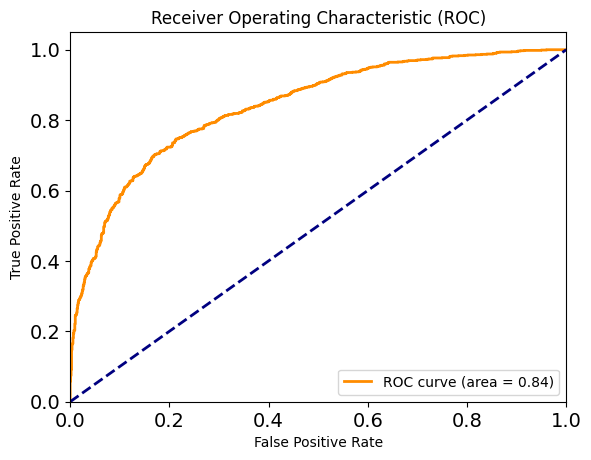

In [ ]:
# Fit logistic classifier on training data
clf = SGDClassifier(
    loss="log",
    penalty="elasticnet",
    max_iter = 5000,
    alpha = 0.0001,
    tol = 0.001
)
clf.fit(train_data, train_labels)

## Pull out the parameters (w,b) of the logistic regression model
w_log = clf.coef_[0,:]
b_log = clf.intercept_

# Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

# Compute accuracy
acc_train = accuracy_score(train_labels, preds_train)
acc_test = accuracy_score(test_labels, preds_test)

print("Training accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

# Precision, Recall, and F1-score
print("Classification Report (Train):")
print(classification_report(train_labels, preds_train))
print("\nClassification Report (Test):")
print(classification_report(test_labels, preds_test))

# Compute ROC curve and ROC area for predictions on test data
fpr, tpr, _ = roc_curve(test_labels, clf.decision_function(test_data))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Fitting a support vector machine (SVM) to the data
From article 2, it claims that SVM is the best model to use for sentiment analysis, thus we will attempt to fit a SVM to the data.

`scikit-learn` provides an SVM solver that we will use. The following routine takes as input the constant `C` (from the above optimization problem) and returns the training and test error of the resulting SVM model. It is invoked as follows:

* `training_error, test_error = fit_classifier(C)`

The default value for parameter `C` is 1.0.

For sentiment analysis, an SVM model works by finding the best boundary that separates data points (in this case, textual data) into classes — for example, positive and negative sentiments. The constant C mentioned in the text is a parameter that the SVM uses to balance the decision boundary margin width and the classification error rate. A smaller value of C allows for a wider margin and more misclassifications (a softer margin), while a larger C leads to a narrower margin and fewer misclassifications (a harder margin), potentially leading to overfitting.

Compared to Logistic Regression, which estimates probabilities that a data point belongs to a particular class, SVM focuses on the separation and is often more effective in higher-dimensional spaces (like text data transformed into TF-IDF features). In sentiment analysis, where the goal is to categorize text as expressing a positive or negative sentiment, SVM can be particularly adept at handling the nuances and complexities of language, often capturing subtle patterns that might be missed by simpler models. The code below would be used to train the SVM on labeled sentiment data, optimizing C to find the best performing model on unseen test data.


In [ ]:
from sklearn import svm
def fit_classifier(C_value=1.0):
    clf = svm.LinearSVC(C=C_value, loss='hinge')
    clf.fit(train_data,train_labels)
    ## Get predictions on training data
    train_preds = clf.predict(train_data)
    train_error = float(np.sum((train_preds > 0.0) != (train_labels > 0.0)))/len(train_labels)
    ## Get predictions on test data
    test_preds = clf.predict(test_data)
    test_error = float(np.sum((test_preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
    ##
    return train_error, test_error

In [ ]:
cvals = [0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
for c in cvals:
    train_error, test_error = fit_classifier(c)
    print ("Error rate for C = %0.2f: train %0.3f test %0.3f" % (c, train_error, test_error))

Error rate for C = 0.01: train 0.218 test 0.279
Error rate for C = 0.10: train 0.196 test 0.268
Error rate for C = 1.00: train 0.090 test 0.244


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Error rate for C = 10.00: train 0.021 test 0.272


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Error rate for C = 100.00: train 0.001 test 0.301


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Error rate for C = 1000.00: train 0.001 test 0.301
Error rate for C = 10000.00: train 0.001 test 0.301


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluating C by k-fold cross-validation

Looking at article 3, we see that the author immediately chose the value of `C` as 1 without any justification. To improve on this in our project, we decide to look at the choice of `C` .

As we can see, the choice of `C` has a very significant effect on the performance of the SVM classifier. We were able to assess this because we have a separate test set. To choose `C`  based solely on a training set, we shall use **`k-fold cross validation`** to estimate the error associated with a specific value of `C`

The function `cross_validation_error` performs k-fold cross-validation to estimate the error of a linear SVM classifier on a given dataset. It takes four parameters: the feature set `x`, the target variable `y`, a regularization parameter `C_value`, and the number of folds `k`. The dataset is shuffled, and then partitioned into `k` subsets. For each fold, it designates a subset as the test set and the remainder as the training set. It then trains the SVM classifier with the specified `C_value` on the training set and evaluates it on the test set, calculating the proportion of misclassified samples. This process is repeated for each fold, and the function returns the average error across all folds. This average error serves as an estimate of the model's performance on unseen data.

In [ ]:
def cross_validation_error(x,y,C_value,k):
    n = len(y)
    ## Randomly shuffle indices
    indices = np.random.permutation(n)

    ## Initialize error
    err = 0.0

    ## Iterate over partitions
    for i in range(k):
        ## Partition indices
        test_indices = indices[int(i*(n/k)):int((i+1)*(n/k) - 1)]
        train_indices = np.setdiff1d(indices, test_indices)

        ## Train classifier with parameter c
        clf = svm.LinearSVC(C=C_value, loss='hinge')
        clf.fit(x[train_indices], y[train_indices])

        ## Get predictions on test partition
        preds = clf.predict(x[test_indices])

        ## Compute error
        err += float(np.sum((preds > 0.0) != (y[test_indices] > 0.0)))/len(test_indices)

    return err/k


## Picking a value of C
The procedure **cross_validation_error** (above) evaluates a single candidate value of `C`. We shall use it repeatedly to identify a good `C`.


In [ ]:
def choose_parameter(x,y,k):
    result = []
    Cs = [1 * 10**(i) for i in range(-4, 4)]
    for c in Cs:
        err = cross_validation_error(x, y, c, k)
        result.append(err)
    min_err = min(result)
    index = result.index(min_err)
    C = 1 * 10**(-4+index)
    plt.plot(np.log(Cs),result)
    plt.xlabel("Log(C)")
    plt.ylabel("Corresponding error")
    return C, min_err


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Choice of C:  1
Cross-validation error estimate:  0.24800469483568074
Test error:  0.24437148217636023


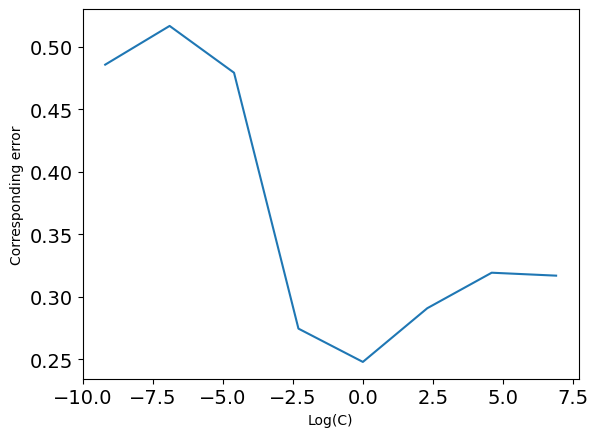

In [ ]:
c, err = choose_parameter(train_data, train_labels, 10)
print("Choice of C: ", c)
print("Cross-validation error estimate: ", err)
## Train it and test it
clf = svm.LinearSVC(C=c, loss='hinge')
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)
error = float(np.sum((preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
print("Test error: ", error)

Training accuracy:  0.9097303634232122
Test accuracy:  0.7556285178236398
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4265
           1       0.92      0.90      0.91      4265

    accuracy                           0.91      8530
   macro avg       0.91      0.91      0.91      8530
weighted avg       0.91      0.91      0.91      8530


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1066
           1       0.76      0.75      0.76      1066

    accuracy                           0.76      2132
   macro avg       0.76      0.76      0.76      2132
weighted avg       0.76      0.76      0.76      2132



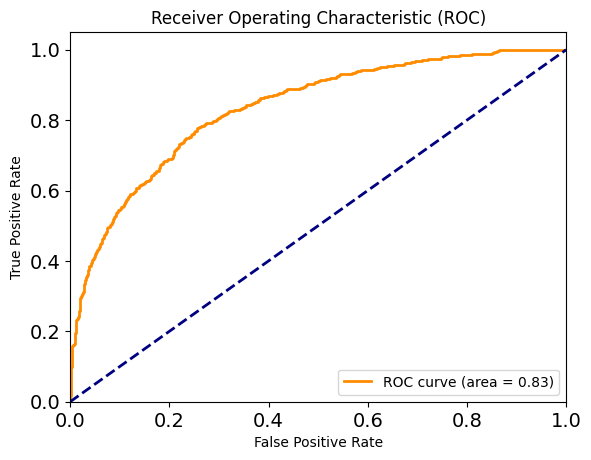

In [ ]:
w_svm = clf.coef_[0,:]
b_svm = clf.intercept_

preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

# Compute accuracy
acc_train = accuracy_score(train_labels, preds_train)
acc_test = accuracy_score(test_labels, preds_test)

print("Training accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

# Precision, Recall, and F1-score
print("Classification Report (Train):")
print(classification_report(train_labels, preds_train))
print("\nClassification Report (Test):")
print(classification_report(test_labels, preds_test))

# Compute ROC curve and ROC area for predictions on test data
fpr, tpr, _ = roc_curve(test_labels, clf.decision_function(test_data))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Words with large influence

Finally, we attempt to partially interpret the logistic regression model and SVM model.

Which words are most important in deciding whether a sentence is positive? As a first approximation to this, we simply take the words whose coefficients in `w` have the largest positive values.

Likewise, we look at the words whose coefficients in `w` have the most negative values, and we think of these as influential in negative predictions.

In [ ]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Get indices of sorting w
inds_log = np.argsort(w_log)
inds_svm = np.argsort(w_svm)

## Words with large negative values
neg_inds_log = inds_log[0:50]
neg_inds_svm = inds_svm[0:50]
print("Highly negative words from logistic regression model: ")
print([str(x) for x in list(vocab[neg_inds_log])])

print("\nHighly negative words from SVM model: ")
print([str(x) for x in list(vocab[neg_inds_svm])])

## Words with large positive values
pos_inds_log = inds_log[-49:-1]
pos_inds_svm = inds_svm[-49:-1]
print("\nHighly positive words from logistic regression model: ")
print([str(x) for x in list(vocab[pos_inds_log])])

print("\nHighly positive words from SVM model: ")
print([str(x) for x in list(vocab[pos_inds_svm])])

Highly negative words from logistic regression model: 
['bad', 'dull', 'worst', 'fails', 'boring', 'flat', 'neither', 'script', 'mess', 'mildly', 'feels', 'idea', 'mediocre', 'nothing', 'jokes', 'thin', 'doesnt', 'supposed', 'minutes', 'generic', 'unfunny', 'would', 'badly', 'video', 'waste', 'bore', 'pretentious', 'exercise', 'title', 'barely', 'plodding', 'things', 'lack', 'loud', 'tries', 'suffers', 'routine', 'tedious', 'problem', 'none', 'premise', 'series', 'stupid', 'thing', 'silly', 'plot', 'much', 'wasnt', 'contrived', 'pointless']

Highly negative words from SVM model: 
['neither', 'fails', 'dull', 'worst', 'bad', 'waste', 'boring', 'supposed', 'badly', 'flat', 'routine', 'mildly', 'generic', 'script', 'tedious', 'lack', 'cold', 'none', 'idea', 'nothing', 'bore', 'jokes', 'doesnt', 'intentions', 'tries', 'disappointment', 'busy', 'money', 'missing', 'contrived', 'lacking', 'superficial', 'cartoon', 'impostor', 'bits', 'title', 'cant', 'plodding', 'thin', 'sheridan', 'reason',

## Sentiment Prediction Tool

The final piece of code you see here is our Sentiment Prediction Tool. It's designed to take any sentence you provide and analyze whether the sentiment behind it is positive or negative. This tool uses the Support Vector Machine (SVM) model we've trained earlier in the notebook. All you need to do is type in a sentence when prompted, and the tool preprocesses your text, converts it into a numerical format that our model understands, and then predicts the sentiment. The model considers the weights and biases learned during training to make its prediction. Give it a try and see how our model performs with your input!


In [ ]:
def predict_sentiment(sentence, vectorizer, clf):
    # Preprocess the input sentence
    processed_sentence = sentence.lower()

    # Vectorize the preprocessed sentence
    sentence_vector = vectorizer.transform([processed_sentence])

    # Append '1' to the feature vector to match the training data
    sentence_vector_with_bias = np.ones((sentence_vector.shape[0], sentence_vector.shape[1] + 1))
    sentence_vector_with_bias[:, :-1] = sentence_vector.toarray()

    # Predict the sentiment using the trained SVM model
    prediction = clf.predict(sentence_vector_with_bias)

    # Convert numerical prediction back to a sentiment label
    sentiment = "positive" if prediction > 0 else "negative"
    return sentiment

# User input
input_sentence = input("Type in a sentence to analyze its sentiment: ")

sentiment = predict_sentiment(input_sentence, vectorizer, clf)
print(f"The sentiment of the sentence is: {sentiment}")